In [4]:
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
import easyocr
from imutils import contours as imutils_contours
from skimage.transform import resize
from skimage.color import rgba2rgb
from skimage import img_as_ubyte


In [5]:
def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()


In [6]:
def isRect(contour):
    (x, y, w, h) = cv2.boundingRect(contour)
    a1 = cv2.contourArea(contour)
    a2 = w*h
    diff = abs(a1-a2)
    return (diff < (0.5 * a2))


In [7]:
def preRatioCheck(width, height, img):
    img_width = img.shape[1]
    img_height = img.shape[0]
    img_area = img_width * img_height
    area = width*height
    min = 0.002*img_area
    max = 0.1*img_area

    ratioMin = 3
    ratioMax = 8

    ratio = float(width) / float(height)

    if (area < min or area > max) or (ratio < ratioMin or ratio > ratioMax):
        return False
    return True


def validateRatio(rect, img):
    (x, y), (width, height), rect_angle = rect
    if rect_angle >= 45:
        (width, height) = (height, width)
    if (height == 0 or width == 0):
        return False
    if not preRatioCheck(width, height, img):
        return False
    else:
        return True

In [8]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlurred = cv2.GaussianBlur(img, (7, 7), 0)
    sobelx = cv2.Sobel(imgBlurred, cv2.CV_8U, 1, 0, ksize=3)
    ret2, threshold_img = cv2.threshold(
        sobelx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    element = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(26, 3))
    element2 = cv2.getStructuringElement(
        shape=cv2.MORPH_RECT, ksize=(10, 3))
    morph_n_thresholded_img = threshold_img.copy()
    img_intermediate = morph_n_thresholded_img
    cv2.morphologyEx(src=threshold_img, op=cv2.MORPH_CLOSE,
                     kernel=element, dst=img_intermediate)
    cv2.morphologyEx(src=img_intermediate, op=cv2.MORPH_OPEN,
                     kernel=element2, dst=morph_n_thresholded_img)
    return morph_n_thresholded_img


In [9]:
def fixRange(img):
    max = np.amax(img)
    if(max <= 1):
        return img
    else:
        return img/255


In [10]:
def restoreRange(img):
    max = np.amax(img)
    if(max > 1):
        return img
    else:
        return img*255

In [11]:
def getLicensePlate(processed_img, img):
    contours, _ = cv2.findContours(processed_img, mode=cv2.RETR_EXTERNAL,
                                   method=cv2.CHAIN_APPROX_NONE)
    imgs = []
    for contour in contours:
        min_rect = cv2.minAreaRect(contour)
        if validateRatio(min_rect, img) and isRect(contour):
            x, y, w, h = cv2.boundingRect(contour)
            after_validation_img = img[y:y + h, x:x + w]
            imgs.append(after_validation_img)
    return imgs


In [12]:
def getPlates():
    plates = []
    imagesWithPlates=[]
    for file in os.listdir(os.fsencode("Images")):
        filename = os.fsdecode(file)
        img = io.imread("./Images/" + filename)
        result = []
        processed_img = preprocess(img)
        result += getLicensePlate(processed_img, img)
        plates += result
        for i in range(len(result)):
            imagesWithPlates.append(filename)
    return plates,imagesWithPlates

In [13]:

def find_end(start,width,black,segmentation_spacing):
    end = start + 1
    black_max = max(black)
    for m in range(start + 1, width - 1):
        if(black[m] > segmentation_spacing * black_max):
            end = m
            break
    return end

In [14]:
def segmentChars(img,segmentation_spacing):

    img = restoreRange(img)
    img = np.array(img, dtype=np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, img_threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

    white = []  # Record the sum of white pixels in each column
    black = []  # Record the sum of black pixels in each column
    height = img_threshold.shape[0]
    width = img_threshold.shape[1]

    for i in range(width):
        white_count = 0
        black_count = 0
        for j in range(height):
            if img_threshold[j][i] == 255:
                white_count += 1
            else:
                black_count += 1

        white.append(white_count)
        black.append(black_count)

    white_max = max(white) 
    n = 1
    chars=[]
    while n < width - 1:
        n += 1
        if(white[n] > (1 - segmentation_spacing) * white_max):
            start = n
            end = find_end(start,width,black,segmentation_spacing)
            n = end
            if end - start > 5:
                character = img[1:height, start:end]
                chars.append(character)      
    return chars                  

In [15]:
#takes array of images of characters return a string of those characters
def getCharAsString(CharImages):
    reader = easyocr.Reader(['en'])
    length = len(CharImages)
    string = ""
    for i in range(length):
        filename = "{}.jpg".format(os.getpid())
        cv2.imwrite(filename, CharImages[i])
        char=reader.readtext(filename, detail = 0)
        os.remove(filename)
        for i in range(len(char)): 
            string+=char[i]   
    return string        

In [16]:
#This Should not be dileverd it is just for testing
#takes image return text inside
def getTextFromImage(image):
    reader = easyocr.Reader(['en'])
    filename = "{}.jpg".format(os.getpid())
    image=restoreRange(image)
    cv2.imwrite(filename, image)
    string=reader.readtext(filename, detail = 0)
    os.remove(filename)
    return string  

In [17]:
def extractCharactersFromPlate(image, resize_state=False, invert=True, threshold=150):
    # image = imutils.resize(image, width=300)
    if resize_state:
        size = image.shape
        image = image[4:size[0]-5][4:size[1]-5]
    plate_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if invert:
        plate_gray = 255-plate_gray
    # kernel = np.ones((3, 3), 'uint8')
    # plate_gray = cv2.dilate(plate_gray, kernel)
    # plate_gray = cv2.erode(plate_gray, kernel)
    thresh = cv2.threshold(plate_gray, threshold, 255, cv2.THRESH_BINARY)[1]
    contours, hierarchy = cv2.findContours(
        thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils_contours.sort_contours(
        contours, method="left-to-right")[0]

    output = []
    for c in contours:
        (x, y, w, h) = cv2.boundingRect(c)
        if h/w > 1 and h/w < 4 and h*w > 0.01*image.shape[0]*image.shape[1]:
            try:
                # part = image[:, x:x +2+ w]
                # output.append(part)
                # OR
                part = thresh[y:y + h, x-1:x+1 + w]
                part = np.hstack(
                    (np.zeros((part.shape[0], 2)), part,  np.zeros((part.shape[0], 2))))
                part = np.vstack(
                    (np.zeros((2, part.shape[1])), part,  np.zeros((2, part.shape[1]))))
                output.append(part.astype('uint8'))
            except:
                continue
    return thresh, output


In [18]:
def getStringFromCharArrays(chars, dilation=False, Erosion=False):
    new_chars = []
    string = ""
    for i in chars:
        i = resize(i, (200, 100))
        new_chars.append(i)
        if dilation:
            kernel = np.ones((3, 3), 'uint8')
            i = cv2.dilate(i, kernel)
        if Erosion:
            kernel = np.ones((2, 2), 'uint8')
            i = cv2.erode(i, kernel)
        char = reader.readtext(img_as_ubyte(i))
        if len(char) > 0:
            string += char[0][1]
    return string


In [19]:
reader = easyocr.Reader(['en'])
def ocrFeed(plate):
    try:
        chars = extractCharactersFromPlate(plate)[1]
        if len(chars) < 4:
            chars = extractCharactersFromPlate(
                plate, threshold=170, resize_state=True)[1]
        if len(chars) < 4:
            chars = extractCharactersFromPlate(
                plate, threshold=170, invert=False, resize_state=True)[1]
    except:
        return []
    string0 = getStringFromCharArrays(chars)
    string1 = getStringFromCharArrays(chars, dilation=True)
    string2 = getStringFromCharArrays(chars, Erosion=True)
    string3 = getStringFromCharArrays(chars, dilation=True, Erosion=True)
    string01 = ""
    string23 = ""
    string = ""
    if len(string0) > len(string1):
        string01 = string0
    else:
        string01 = string1
    if len(string2) > len(string3):
        string23 = string2
    else:
        string23 = string3
    if len(string23) > len(string01):
        string = string23
    else:
        string = string01
    return string

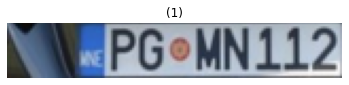

P6MN112


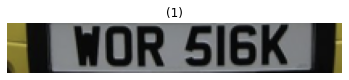

40R56K


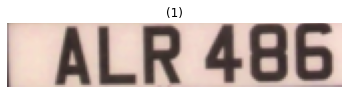

ALR4A6


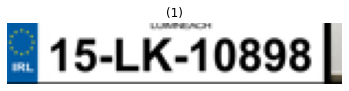

815LK10898


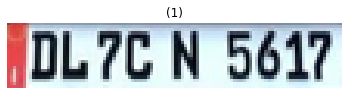

0L2CM561'7


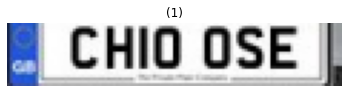

CH005FL


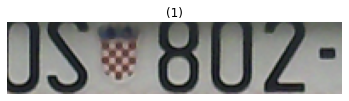

1)8(1L


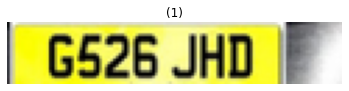

6525JH0I


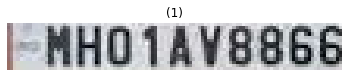

4H01aM8866


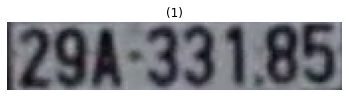

2933185


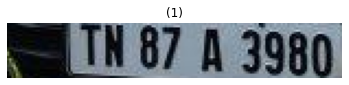

TM8143990


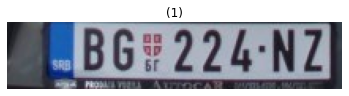

R6224N1


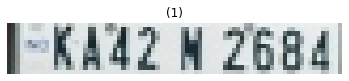

K44L7#204


In [20]:
plates, imagesWithPlates = getPlates()
for plate in plates[:40]:
    string = ocrFeed(plate)
    if len(string) > 4:
        show_images([plate])
        print(string)
